# Data Mining Tutorial Week 7 
## Anomaly Detection
The following tutoiral contains examples for **anomaly detection** in three different ways: **density-based** model, **statistical** approach, and **distance-based** approach.

Python library used in this tutorial: numpy, matplotlib, pandas, scikit-learn, scipy. Make sure you have already installed them using conda or pip.

Datasets: dummy_data0.csv, dummy_data1.csv, outlier_mnist.csv.

# Part 1: Density Based Model - Local Outlier Factor (LOF)
In this part, given a dummy dataset **dummy_data1.csv**, we will load the data, calculate the local outlier factor, and visualise the outlier detection result.

## 1.1 Data preparation

<Figure size 432x432 with 0 Axes>

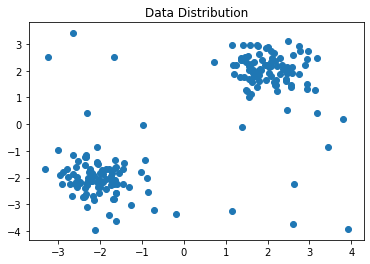

<Figure size 432x432 with 0 Axes>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

# Load data
data_frame = pd.read_csv('dummy_data1.csv') # data frame is 3 colmuns x, y, label
X = data_frame[['x', 'y']].values # value is vector
label = data_frame['label'].values

# Data distribution visualization
plt.scatter(X[:, 0], X[:, 1]) # Plot data points distribution
plt.title('Data Distribution') 
plt.figure(figsize=(6,6))

## 1.2 Fit the Model
Local Outlier Factor (LOF) method is an effective way to detect outliers based on data density. 

We are using the **LocalOutlierFactor** function from scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

For more examples, also check here: https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html

In [7]:
# Fit the model for outlier detection
clf = LocalOutlierFactor(n_neighbors=20, # number of neighbours
                         contamination=0.1) # define the threshold on the score of the sample

# Use fit_predict to compute the predicted labels of the training samples
y_pred = clf.fit_predict(X)
n_errors = (y_pred != label).sum() # count the number of wrong predictions
X_scores = -clf.negative_outlier_factor_ # High LOF: Outliers, Low LOF: Inliers.
print ("Number of error: %d" % n_errors)

# Print top-n predicted outliers
n = 10 # also try n=20 to see if there are any errors
result = {'Label': label, 'Anomaly score': X_scores}
result = pd.DataFrame(data = result)
result.nlargest(n,'Anomaly score') # -1: outliers, 1: inliers, nlargest is sort function

Number of error: 2


,Label,Anomaly score
197,-1.0,5.848422
188,-1.0,5.242525
190,-1.0,4.675327
184,-1.0,4.330019
181,-1.0,3.755870
192,-1.0,3.541896
186,-1.0,3.400015
189,-1.0,3.293055
191,-1.0,3.135418
185,-1.0,3.055826


## 1.3 Visualisation

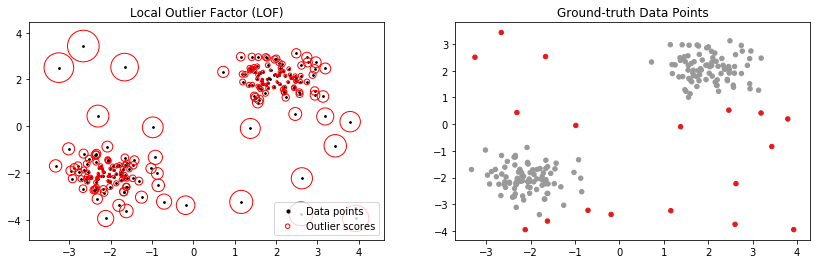

In [7]:
# Initialize the subplots
fig, axs = plt.subplots(1, 2, # set figure row and col
                        figsize=(14, 4)) # set fifg size

axs[0].set_title("Local Outlier Factor (LOF)")
axs[0].scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points') # "s" is plot size

# plot circles with radius proportional to the outlier scores
radius = (X_scores - X_scores.min()) / (X_scores.max() - X_scores.min())
axs[0].scatter(X[:, 0], X[:, 1], s=1000 * radius,
               edgecolors='r', # edge color
               facecolors='none', # inside color
               label='Outlier scores')

legend = axs[0].legend(loc='lower right')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]


# Compare with ground-truth. Grey: inliers, Red: outliers.
axs[1].set_title("Ground-truth Data Points")
axs[1].scatter(X[:, 0], X[:, 1], c=label, s=20, cmap='Set1')

## Part 2: Statistical Approach
This approach assumes that the majority of the data instances are governed by some well-known **probability distribution**, e.g., Binomial or Gaussian distribution. Anomalies can then detected by seeking for observations that do not fit the overall distribution of the data.

In this example, the goal is to detect the abnormal data points that do not fit the overall distribution. Two different dataset will be demostrated: dummy_data0.csv, dummy_data1.csv

## 2.1 Data preparation

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

# Load data
data_frame = pd.read_csv('dummy_data0.csv')
X = data_frame[['x', 'y']].values
label = data_frame['label'].values

## 2.2 Mean and Covariance
Assuming the data follows a **multivariate Gaussian distribution**, we can compute the mean vector and covariance matrix of the 2-dimensional data as follows:

In [9]:
meanValue = np.mean(X, axis=0)
covValue = np.cov(X.T) # X.T means that transpose of the X
print('Mean:\n', meanValue)
print ('Cov:\n', covValue)

Mean:
 [-0.05379574 -0.06025749]
Cov:
 [[ 1.46340624 -0.24750653]
 [-0.24750653  1.54436836]]


## 2.3 Anomaly Score
To calculate the anomaly score, we will use the **Mahalanobis distance**. The Mahalanobis distance is a measure of the distance between a point P and a distribution D.
\begin{equation}
\textrm{Mahalanobis}(x) = (x - \bar{x}) \Sigma^{-1}(x - \bar{x})^T
\end{equation}
where $x$ is assumed to be a row vector.

In [13]:
# Define the Mahalanobis distance calculation function
def mahalanobis(x=None, data=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    """
    x_minus_mu = x - np.mean(data, axis=0) #np.mean calculate colm average
    cov = np.cov(data.T) # compute covariance
    
    inv_covmat = sp.linalg.inv(cov) #compute a inverse of the matrix
    left_term = np.dot(x_minus_mu, inv_covmat) # dot product
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Mahalanobis distance Calculation
anomaly_score = mahalanobis(x=X, data=X)

# Rank the anomaly scores (Descending)
n=10 # also try n=20 to see if there are any errors
anom = pd.DataFrame(anomaly_score, index=data_frame.index, columns=['Anomaly score']) #create dataframe
result = pd.concat((data_frame, anom), axis=1) # concat can set logic along with the other axes
result.nlargest(n,'Anomaly score') # Labels with -1: outliers, 1: inliers

,x,y,label,Anomaly score
182,3.92502,-3.94539,-1.0,17.685207
192,-2.11965,-3.94758,-1.0,14.862883
180,2.60396,-3.74843,-1.0,11.807831
181,-1.61902,-3.62643,-1.0,11.441659
194,-2.65963,3.43103,-1.0,10.833712
184,3.79165,0.19532,-1.0,10.651079
190,-2.84791,-2.30243,-1.0,10.239882
185,-3.25110,2.50647,-1.0,9.717381
183,3.43159,-0.83637,-1.0,8.324303
193,3.18915,0.41788,-1.0,7.887908


## 2.4 Visualisation

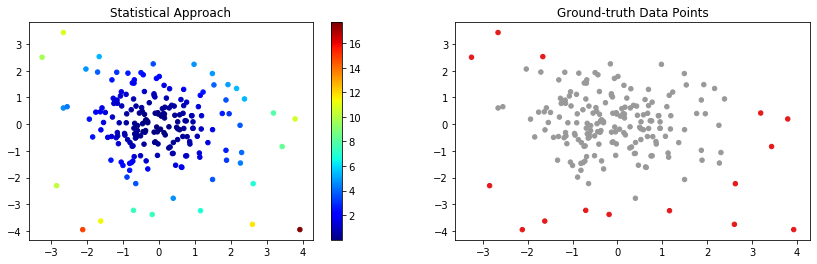

In [16]:
# Plot the data
fig, axs = plt.subplots(1, 2, figsize=(14, 4)) # Initialize the subplots
axs[0].set_title("Statistical Approach")
im1 = axs[0].scatter(data_frame.x,data_frame.y,  s=20,
                     c=anomaly_score, #color label
                     cmap='jet') #color pallet type
fig.colorbar(im1,ax=axs[0]) #set color bar

axs[1].set_title("Ground-truth Data Points")
im2 = axs[1].scatter(data_frame.x,data_frame.y, 
                     c=label, # set color label
                     s=20, cmap='Set1')

## 2.5 Another dataset

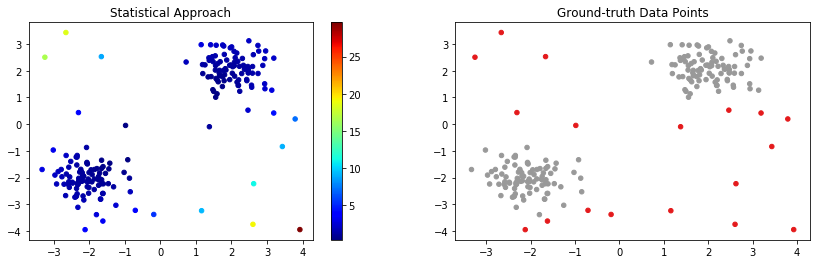

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

# Load data
data_frame = pd.read_csv('dummy_data1.csv') # another dataset
X = data_frame[['x', 'y']].values
label = data_frame['label'].values

# Define the Mahalanobis distance calculation function
def mahalanobis(x=None, data=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    """
    x_minus_mu = x - np.mean(data, axis=0)
    cov = np.cov(data.T)
    
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Mahalanobis distance Calculation
anomaly_score = mahalanobis(x=X, data=X)

fig, axs = plt.subplots(1, 2, figsize=(14, 4)) # Initialize the subplots

axs[0].set_title("Statistical Approach")
im1 = axs[0].scatter(data_frame.x,data_frame.y, s=20,
                     c=anomaly_score, cmap='jet')
fig.colorbar(im1, ax=axs[0])
axs[1].set_title("Ground-truth Data Points")
im2 = axs[1].scatter(data_frame.x,data_frame.y,
                     c=label, s=20, cmap='Set1')

We can see this method works well on the outliers who are far away from both clusters, but it doesn't work very well on outliers in the middle of two clusters.

# Part 3: Distance-based Approach

This is a model-free anomaly detection approach as it does not require constructing an explicit model of the normal class to determine the anomaly score of data instances. The example code shown below employs the k-nearest neighbor approach to calculate anomaly score. Specifically, a normal instance is expected to have a small distance to its k-th nearest neighbor whereas an anomaly is likely to have a large distance to its k-th nearest neighbor.

## 3.1 Data preparation

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance

# Load data
data_frame = pd.read_csv('dummy_data0.csv')
X = data_frame[['x', 'y']].values
label = data_frame['label'].values

## 3.2 Distance calculation

In [26]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy.spatial import distance

# Find the k-NearestNeighbours (kNN)
knn = 4 # set the number of k-nearest neighbours
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(X)
distances, indices = nbrs.kneighbors(X) # compute distance and indices

# Anomaly_score: distance between data points and their k-th nearest neighbor
anomaly_score = distances[:,knn-1] # extract anomary score, which is the farest distance of the point

# Print top predicted outliers
n=10 # also try n=20 to see if there are any errors
anom = pd.DataFrame(anomaly_score, index=data_frame.index, columns=['Anomaly score'])
result = pd.concat((data_frame,anom), axis=1)
result.nlargest(n,'Anomaly score') # -1: outliers, 1: inliers

,x,y,label,Anomaly score
182,3.92502,-3.94539,-1.0,2.855216
190,-2.84791,-2.30243,-1.0,1.806418
192,-2.11965,-3.94758,-1.0,1.799133
185,-3.25110,2.50647,-1.0,1.589412
184,3.79165,0.19532,-1.0,1.550648
180,2.60396,-3.74843,-1.0,1.532583
194,-2.65963,3.43103,-1.0,1.504330
181,-1.61902,-3.62643,-1.0,1.453470
188,1.15868,-3.23855,-1.0,1.352750
183,3.43159,-0.83637,-1.0,1.277466


## 3.3 Visualisation

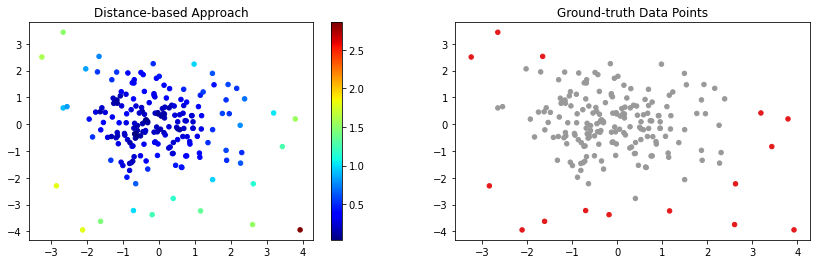

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4)) # Initialize the subplots

axs[0].set_title("Distance-based Approach")
im1 = axs[0].scatter(data_frame.x,data_frame.y,  s=20, c=anomaly_score,cmap='jet')
fig.colorbar(im1,ax=axs[0])

axs[1].set_title("Ground-truth Data Points")
im2 = axs[1].scatter(data_frame.x,data_frame.y, c=label, s=20, cmap='Set1')

The lighter data points are the predicted outliers.

## 3.4 Another dataset

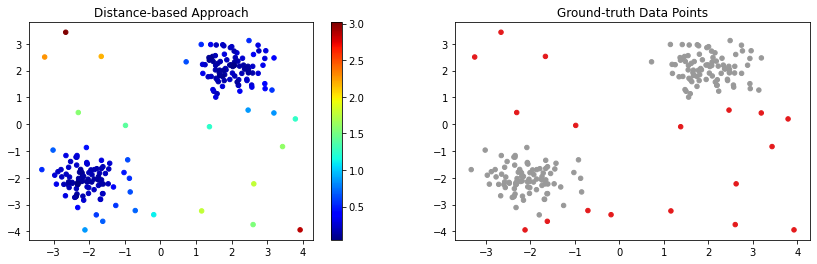

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance

# Load data
data_frame = pd.read_csv('dummy_data1.csv')
X = data_frame[['x', 'y']].values
label = data_frame['label'].values

# Calculate the anomaly score
knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(X)
distances, indices = nbrs.kneighbors(X)

anomaly_score = distances[:,knn-1]

# Visualisation
fig, axs = plt.subplots(1, 2, figsize=(14, 4)) # Initialize the subplots

axs[0].set_title("Distance-based Approach")
im1 = axs[0].scatter(data_frame.x,data_frame.y,  s=20, c=anomaly_score,cmap='jet')
fig.colorbar(im1,ax=axs[0])

axs[1].set_title("Ground-truth Data Points")
im2 = axs[1].scatter(data_frame.x,data_frame.y, c=label, s=20, cmap='Set1')

This time, the outliers between clusters can also be detected.

## 3.5 One more dataset... MNIST Digits

We have 200 samples in total, 180 "One"s, 20 "Zero"s as outliers.

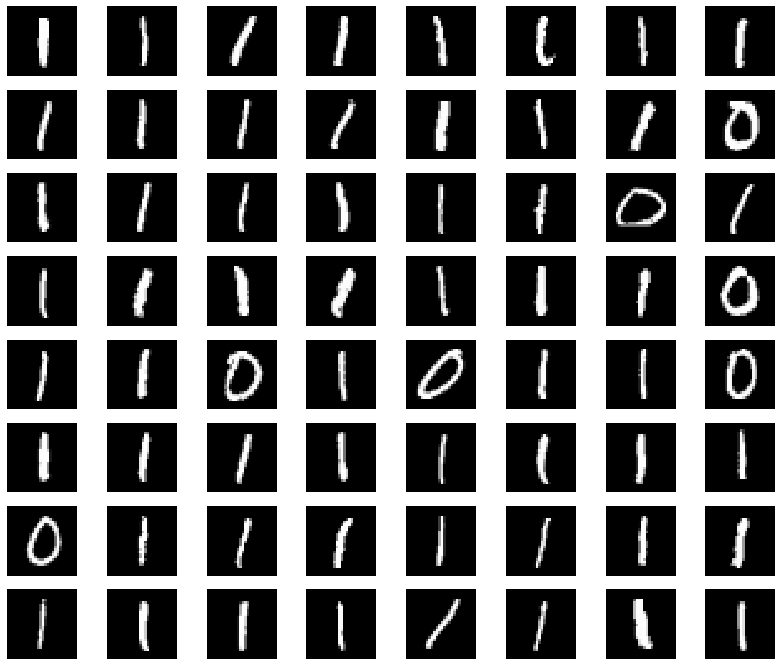

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance

# Load data
data_frame = pd.read_csv('outlier_mnist.csv',header=None)
X = data_frame.values[:, 1:] # array
label = data_frame.values[:,0] # array

images = X.reshape(label.shape[0], 28, 28) # Reshape the array to actual image dimension (# of images, x_dim, y_dim)

# Have a look at the data
row = 8 # Number of rows in the subplot  
column = 8 # Number of columns in the subplot
fig, axs = plt.subplots(row, column, figsize = (14, 12))
plt.gray() # We would like the imgs are shown in the grayscale.
for i in range(row):
    for j in range(column):
        axs[i][j].matshow(images[i*column+j]) # For each row, we display one class of digits
        axs[i][j].axis('off')

In [40]:
# Fit the model
knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(X)
distances, indices = nbrs.kneighbors(X)

anomaly_score = distances[:,knn-1]
# print (anomaly_score)
anom = pd.DataFrame(anomaly_score, index=data_frame.index, columns=['Anomaly score'])
result = pd.concat((data_frame,anom), axis=1) # concat first column 'label' and anomaly scores

Ground-truth of top-40: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Anomaly Scores: 36     2558.396177
142    2462.191707
133    2439.184290
134    2289.622240
22     2276.650390
Name: Anomaly score, dtype: float64


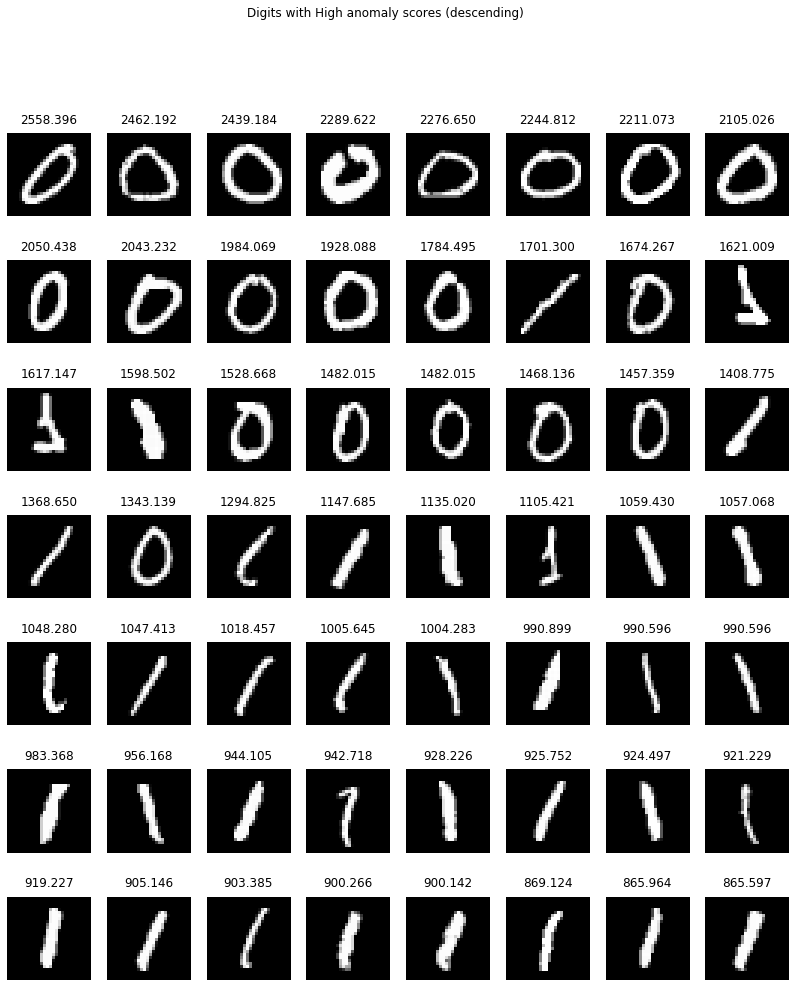

In [41]:
# Visualisation

# Sort by anomaly score
result = result.sort_values(by=['Anomaly score'],ascending=False)
ordered_idx = result.index
print ('Ground-truth of top-40:', result.values[:40, 0])
print ('Anomaly Scores:', result['Anomaly score'].head())

# Have a look at the data
row = 7 # Number of rows in the subplot  
column = 8 # Number of columns in the subplot
fig, axs = plt.subplots(row, column, figsize = (14, 16))
fig.suptitle('Digits with High anomaly scores (descending)')
plt.gray() # We would like the imgs are shown in the grayscale.
for i in range(row):
    for j in range(column):
        idx = i*column+j
        axs[i][j].matshow(images[ordered_idx[idx]])
        axs[i][j].set_title('%.3f' % result['Anomaly score'].iloc[idx])
        axs[i][j].axis('off')
    
# display the figure
plt.show()

As we can see, in the final prediction, most of the "Zeros" have very high anomaly scores.